# Undersampling

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The training data for each classifier is adjusted using *undersampling*.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import BagOfWordsTransformer, Word2VecTransformer, FastTextTransformer, Doc2VecTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

<a id='data_preparation'/>

## Data Preparation

In [4]:
def create_classifier(classifier_options, name, embedding=''):
    classifier = ClasswiseClassifier(name, classifier_options, embedding, undersample=True)
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    experimental_classifier.train(train, y_train)
    experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods.
- Linear SVC
- Logistic Regression
- MLPClassifier

As seen in [notebook 1.0](1.0-me-initial-data-exploration.ipynb) the data for each label is unbalanced. The majority class is generally present for ~90% of the data. Leading to a very high probability for the majority class: the label not being predicted. Since the final application is supposed to act as a recommender, it should prioritise to predict if there is any chance of that label fitting the sample. Undersampling can help to balance this issue.
Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.

In [5]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [6]:
transformer = Word2VecTransformer.load('word2vec')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'word2vec')

Classifier not available. Initiating data.
Training: 21.23663330078125s
Test: 2.1906659603118896s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012980334754661746     0.060459492140266025     0.3760945087426345       0.25518742442563486      0.27578088712308785      
micro                                                            0.5257710402509148       0.2407487194217052       0.33026860182570433      
macro                                                            0.3386274892155099       0.2262061264062794       0.2297599190077961       


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'word2vec')

Classifier not available. Initiating data.
Training: 18.44517755508423s
Test: 2.238161563873291s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012338827722268186     0.06698911729141475      0.3392511660044913       0.19902458686013705      0.2314408988834624       
micro                                                            0.6193353474320241       0.18646177413949927      0.2866288910147914       
macro                                                            0.3319325631117933       0.10181584025230642      0.13854887441391175      


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'word2vec')

Classifier not available. Initiating data.
Training: 1748.0676991939545s
Test: 9.827969312667847s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017001845605549546     0.03349455864570738      0.3921072005382767       0.40662031438935914      0.35980963682293793      
micro                                                            0.36973437080762006      0.39580640528507827      0.3823264201983769       
macro                                                            0.25466979864923334      0.37836846668821117      0.2776488453667269       


**Doc2Vec**

In [10]:
transformer = Doc2VecTransformer.load('doc2vec')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [11]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'doc2vec')

Classifier not available. Initiating data.
Training: 177.36747813224792s
Test: 5.177180051803589s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.029475593457646533     0.013301088270858524     0.12714829545294562      0.2085993550987505       0.13139113017309104      
micro                                                            0.12853553062178588      0.21058930537603524      0.1596356576488306       
macro                                                            0.1754098166743089       0.31144660400485263      0.14175036297843363      


In [12]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'doc2vec')

Classifier not available. Initiating data.
Training: 18.773534059524536s
Test: 3.6323025226593018s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.025237701266467256     0.024788391777509067     0.19040401768814527      0.2657496977025393       0.18394257251721807      
micro                                                            0.18764355380979328      0.26985494758006606      0.22136265462399368      
macro                                                            0.170659051527614        0.33021062593810213      0.17541696365570184      


In [13]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'doc2vec')

Classifier not available. Initiating data.
Training: 1140.1959943771362s
Test: 9.3963041305542s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02499904537643989      0.014510278113663845     0.25220705790950637      0.3425554212011286       0.25577237522798507      
micro                                                            0.21782755446455968      0.3398439370003351       0.2654873875726921       
macro                                                            0.17838733407108423      0.38285260839092516      0.21317479723209953      


**FastText**

In [14]:
transformer = FastTextTransformer.load('fasttext')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [15]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'fasttext')

Classifier not available. Initiating data.
Training: 20.95685124397278s
Test: 2.298396348953247s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01252784318716986      0.06783555018137848      0.3993278919790407       0.27194074969770254      0.29417395583054584      
micro                                                            0.563315103071098        0.25640289147398154      0.352403197683982        
macro                                                            0.4277184827011048       0.25219694661582664      0.2731242168378987       


In [16]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'fasttext')

Classifier not available. Initiating data.
Training: 19.160714149475098s
Test: 2.3303284645080566s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012248456691911156     0.0690447400241838       0.315146110439339        0.18466142684401451      0.2152433291550583       
micro                                                            0.6485264870728621       0.1717171717171717       0.27153671461014384      
macro                                                            0.3337386382923018       0.08523724405190206      0.12120217933698602      


In [17]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'fasttext')

Classifier not available. Initiating data.
Training: 1801.6574981212616s
Test: 10.072187185287476s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017113218354228982     0.031801692865779926     0.39604915674141794      0.4067956469165659       0.36016673946700045      
micro                                                            0.36729910220689044      0.39757767245918907      0.3818390804597701       
macro                                                            0.26152267975593485      0.40609253702021586      0.291616743372537        


**TFIDF**

In [18]:
transformer = BagOfWordsTransformer.load('tfidf', 'basic', 'lsa')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [19]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'tfidf')

Classifier not available. Initiating data.
Training: 407.99031019210815s
Test: 17.147217988967896s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01178132756316426      0.09081015719467957      0.518393600890578        0.4033131801692866       0.41886949474011137      
micro                                                            0.5841892753417866       0.39480109148355597      0.4711763697651831       
macro                                                            0.4946026466726823       0.3932772042019756       0.41908900808901495      


In [20]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'tfidf')

Classifier not available. Initiating data.
Training: 302.9610848426819s
Test: 17.278393745422363s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01133456373703303      0.0875453446191052       0.41998819600391557      0.2471100362756953       0.28987200559751947      
micro                                                            0.7216064488268318       0.23998276604911675      0.3601810604971979       
macro                                                            0.46907467174262396      0.13848068049085835      0.19647264482169863      


In [21]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'tfidf')

Classifier not available. Initiating data.
Training: 11198.612640619278s
Test: 70.00099420547485s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013495195061414115     0.06577992744860943      0.47029879464885505      0.4227347843611447       0.4092556053378303       
micro                                                            0.49110760918505175      0.41773182057542246      0.45145769200920915      
macro                                                            0.4084342769017441       0.43857571053400846      0.4105975886219641       


**Count**

In [22]:
transformer = BagOfWordsTransformer.load('count', 'basic', 'lsa')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [23]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-undersampled', 'count')

Classifier not available. Initiating data.
Training: 1563.0741589069366s
Test: 19.859023332595825s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.019829440590593776     0.026239419588875452     0.3541358570893033       0.45770858524788394      0.36211251631917735      
micro                                                            0.32526799387442573      0.45756139595002154      0.38023630504833517      
macro                                                            0.2976661376466945       0.46963200249528014      0.3543102240019179       


In [24]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-undersampled', 'count')

Classifier not available. Initiating data.
Training: 515.9333262443542s
Test: 19.55438232421875s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015294342264367084     0.05610640870616687      0.4363839991231323       0.4230229746070133       0.38809732439044625      
micro                                                            0.42458851192475644      0.42357221504140935      0.42407975460122704      
macro                                                            0.3531152251719913       0.41789581388661373      0.37162571734570676      


In [25]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-undersampled', 'count')

Classifier not available. Initiating data.
Training: 7460.54652094841s
Test: 64.1057960987091s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.016168777445427353     0.055985489721886335     0.4459864404364553       0.45171906489318825      0.4072588022603933       
micro                                                            0.40255425637485437      0.4466465603906362       0.42345572550265514      
macro                                                            0.3153622021870853       0.48103993805391876      0.3568957374009226       


<a id='evaluation'/>

## Evaluation

In [4]:
paths = available_classifier_paths('undersampled')

In [5]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    evals.append([name + ' ' + transformer, evaluation])

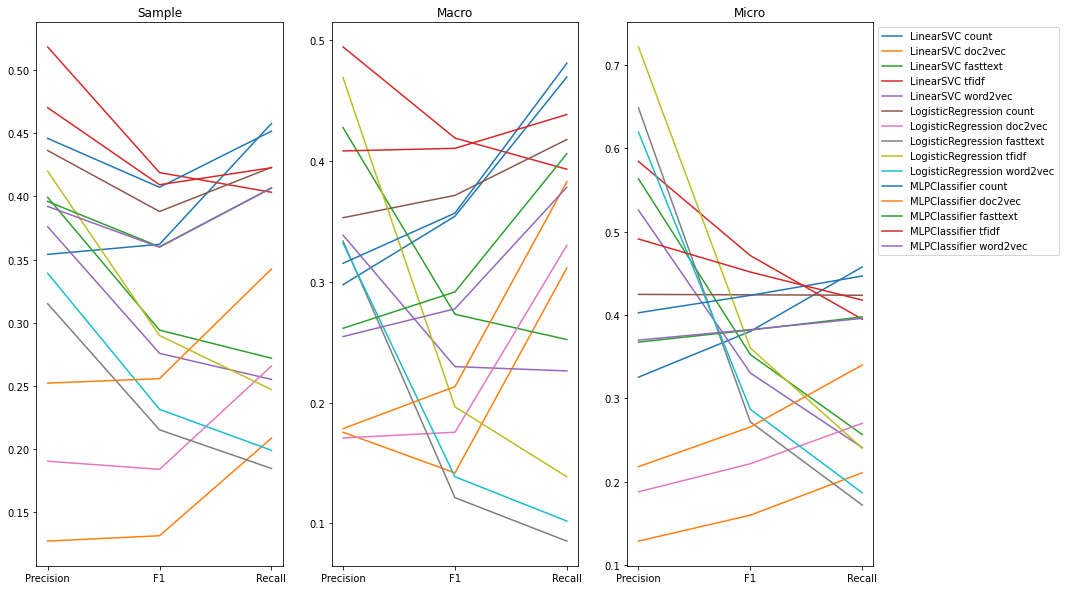

In [6]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [7]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [8]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [9]:
from sklearn.metrics import classification_report
classwise_results = []
for path in top_3:
    clf = load(path)
    test = clf.transform(X_test)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    classwise_results.append((name + ' ' + transformer, classwise_report))

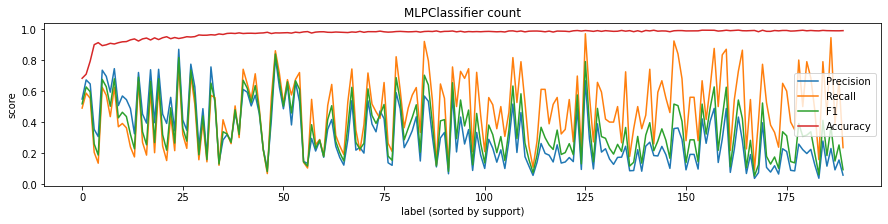

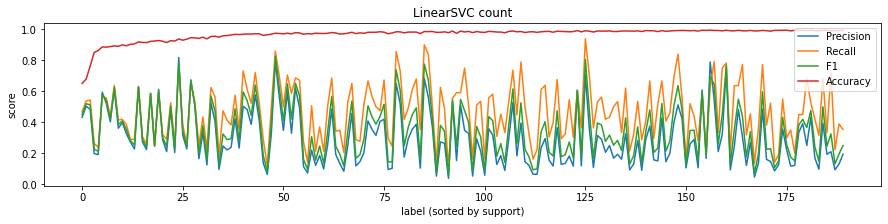

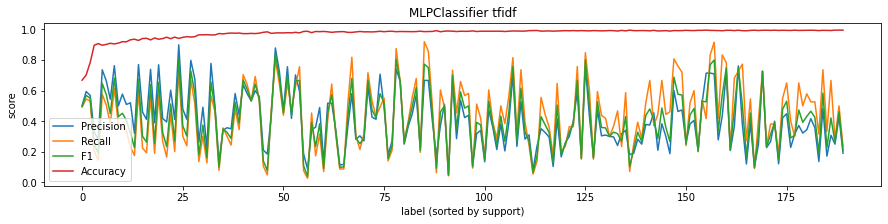

In [10]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()